In [17]:
import os
import librosa
import torch
import torchaudio
import numpy as np
from sklearn.model_selection import train_test_split

# Path to dataset
DATA_PATH = "/kaggle/input/google-speech-commands/"

# Hyperparameters
SAMPLE_RATE = 16000
DURATION = 1.0  
N_MELS = 128
N_FFT = 400

def load_audio(file_path, target_sr=SAMPLE_RATE, duration=DURATION):
    """Load and preprocess audio file"""
    audio, sr = librosa.load(file_path, sr=target_sr, duration=duration)
    audio = librosa.util.fix_length(audio, size=int(target_sr * duration))  # Pad/Trim
    return audio

def extract_features(file_path):
    """Extract mel spectrogram features"""
    audio = load_audio(file_path)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db


In [28]:
import os
import librosa
import torch
import torchaudio
import numpy as np
import random
from sklearn.model_selection import train_test_split

# Path to dataset
DATA_PATH = "/kaggle/input/google-speech-commands/"

# Hyperparameters
SAMPLE_RATE = 16000
DURATION = 1.0  
N_MELS = 128
N_FFT = 400

# Audio augmentations
def add_noise(audio, noise_level=0.005):
    return audio + noise_level * np.random.randn(len(audio))

def time_shift(audio, shift_max=0.2):
    shift = int(np.random.uniform(-shift_max, shift_max) * len(audio))
    return np.roll(audio, shift)

def change_pitch(audio, sr, pitch_factor=2):
    return librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=random.uniform(-pitch_factor, pitch_factor))


def change_speed(audio, speed_factor_range=(0.9, 1.1)):
    speed = random.uniform(*speed_factor_range)
    return librosa.effects.time_stretch(audio, rate=speed)

def apply_audio_augmentations(audio, sr):
    if random.random() < 0.5:
        audio = add_noise(audio)
    if random.random() < 0.5:
        audio = time_shift(audio)
    if random.random() < 0.5:
        audio = change_pitch(audio, sr)
    if random.random() < 0.5:
        audio = change_speed(audio)
    return audio

# Load and preprocess
def load_audio(file_path, target_sr=SAMPLE_RATE, duration=DURATION, augment=False):
    audio, sr = librosa.load(file_path, sr=target_sr, duration=duration)
    audio = librosa.util.fix_length(audio, size=int(target_sr * duration))
    if augment:
        audio = apply_audio_augmentations(audio, sr)
    return audio

# def extract_features(file_path, augment=False):
#     audio = load_audio(file_path, augment=augment)
#     mel_spec = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT)
#     mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
#     return mel_spec_db

MAX_TIME_STEPS = 32  # based on your analysis

def extract_features(file_path, augment=False):
    audio = load_audio(file_path, augment=augment)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Pad or truncate along the time axis
    if mel_spec_db.shape[1] < MAX_TIME_STEPS:
        pad_width = MAX_TIME_STEPS - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_spec_db = mel_spec_db[:, :MAX_TIME_STEPS]

    return mel_spec_db


def create_balanced_dataset(data_path, augment=False):
    X, y = [], []
    all_items = sorted(os.listdir(data_path))
    classes = [item for item in all_items 
               if os.path.isdir(os.path.join(data_path, item)) 
               and item != "_background_noise_"]

    label_map = {label: idx for idx, label in enumerate(classes)}

    class_to_files = {cls: [] for cls in classes}
    for label in classes:
        folder = os.path.join(data_path, label)
        for file_name in os.listdir(folder):
            file_path = os.path.join(folder, file_name)
            if file_path.endswith(('.wav', '.mp3', '.flac')):
                class_to_files[label].append(file_path)

    min_class_count = min(len(files) for files in class_to_files.values())

    for label in classes:
        selected_files = class_to_files[label][:min_class_count]
        for file_path in selected_files:
            features = extract_features(file_path, augment=augment)
            X.append(features)
            y.append(label_map[label])
    
    return np.array(X), np.array(y), label_map

# Load dataset (without augmentation here)
X, y, label_map = create_balanced_dataset(DATA_PATH,augment=True)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from torch.utils.data import Dataset, DataLoader
import torchaudio.transforms as T
import torch.nn as nn

# Dataset with spectrogram augmentation
class AudioDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # (B, 1, Mels, Time)
        self.y = torch.tensor(y, dtype=torch.long)
        self.augment = augment

        self.augment_pipeline = nn.Sequential(
            T.TimeMasking(time_mask_param=20),
            T.FrequencyMasking(freq_mask_param=15)
        )

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.augment:
            x = self.augment_pipeline(x)
        return x.squeeze(0), self.y[idx]  # return (Mels, Time)

# Create Datasets
train_dataset = AudioDataset(X_train, y_train, augment=True)
test_dataset = AudioDataset(X_test, y_test, augment=False)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [27]:
def get_time_lengths(data_path, sample_count=1000):
    lengths = []
    count = 0
    all_items = sorted(os.listdir(data_path))
    classes = [item for item in all_items 
               if os.path.isdir(os.path.join(data_path, item)) 
               and item != "_background_noise_"]

    for label in classes:
        folder = os.path.join(data_path, label)
        for file_name in os.listdir(folder):
            file_path = os.path.join(folder, file_name)
            if file_path.endswith(('.wav', '.mp3', '.flac')):
                audio = load_audio(file_path)
                mel_spec = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT)
                lengths.append(mel_spec.shape[1])
                count += 1
                if count >= sample_count:
                    return lengths
    return lengths

# Estimate time steps
lengths = get_time_lengths(DATA_PATH, sample_count=1000)
MAX_TIME_STEPS = int(np.percentile(lengths, 95))
print("Estimated MAX_TIME_STEPS:", MAX_TIME_STEPS)


Estimated MAX_TIME_STEPS: 32


In [3]:
import os
from collections import defaultdict

def count_files_per_class(data_path):
    class_counts = defaultdict(int)
    for label in os.listdir(data_path):
        folder = os.path.join(data_path, label)
        if os.path.isdir(folder) and label != "_background_noise_":
            for file_name in os.listdir(folder):
                if file_name.endswith(('.wav', '.mp3', '.flac')):
                    class_counts[label] += 1
    return class_counts

# Show file counts
file_counts = count_files_per_class(DATA_PATH)
for cls, count in file_counts.items():
    print(f"{cls}: {count} files")


no: 2375 files
two: 2373 files
four: 2372 files
five: 2357 files
nine: 2364 files
right: 2367 files
off: 2357 files
yes: 2377 files
six: 2369 files
dog: 1746 files
left: 2353 files
bird: 1731 files
wow: 1745 files
zero: 2376 files
eight: 2352 files
bed: 1713 files
go: 2372 files
house: 1750 files
tree: 1733 files
seven: 2377 files
on: 2367 files
three: 2356 files
one: 2370 files
down: 2359 files
stop: 2380 files
up: 2375 files
happy: 1742 files
marvin: 1746 files
cat: 1733 files
sheila: 1734 files


In [4]:
import librosa

array, sampling_rate = librosa.load("/kaggle/input/google-speech-commands/bed/00176480_nohash_0.wav")

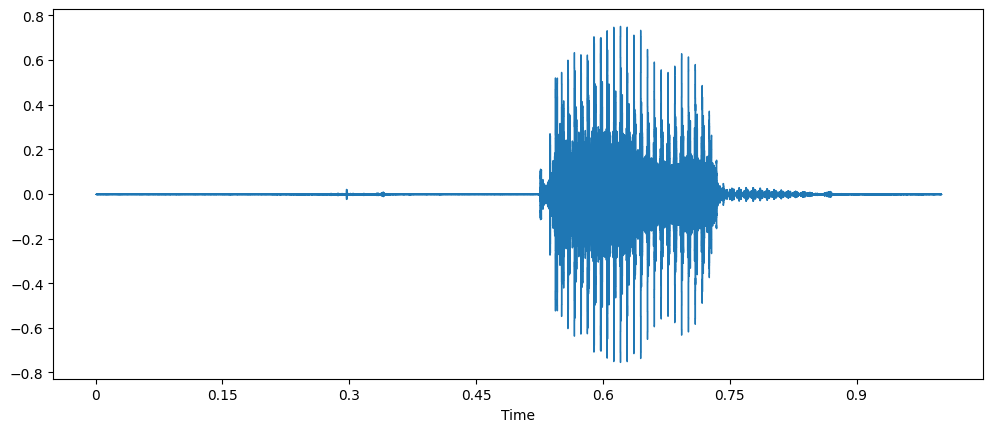

In [5]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

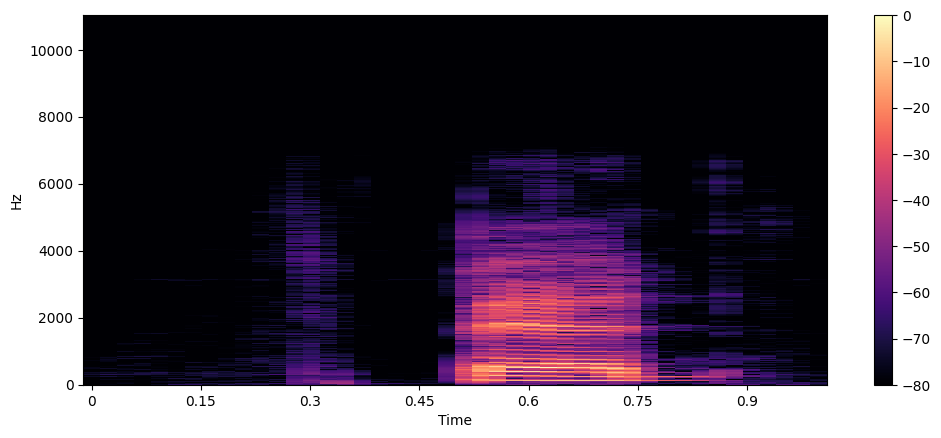

In [6]:
#Plot Spectogram
import numpy as np

D = librosa.stft(array)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()

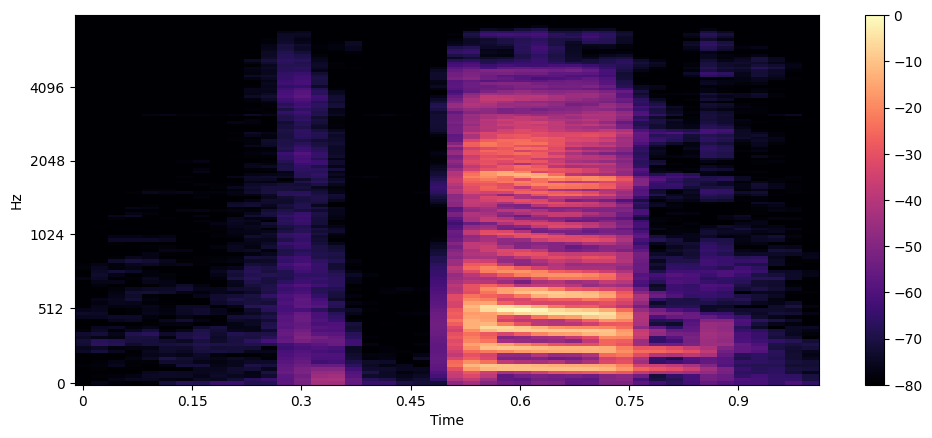

In [7]:
#plot mel spectogram

S = librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=8000)
plt.colorbar()

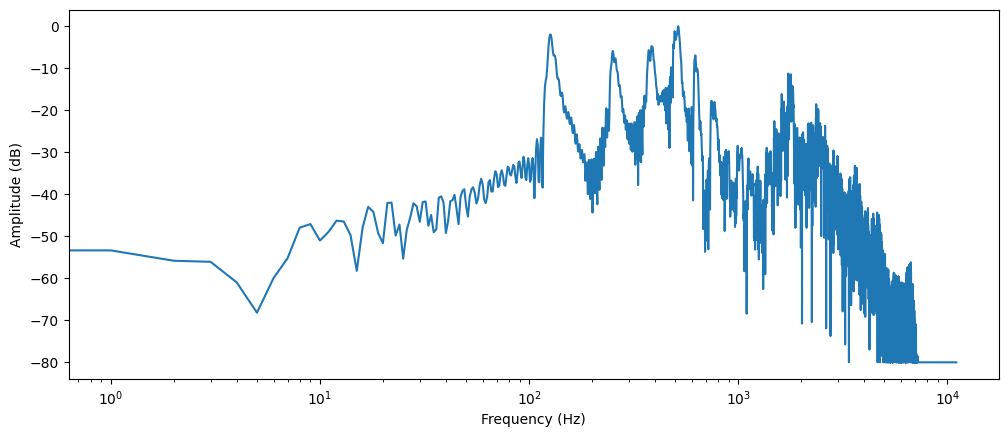

In [8]:
import numpy as np

dft_input = array[:22050]

# calculate the DFT
window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

# get the amplitude spectrum in decibels
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# get the frequency bins
frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

In [ ]:
def create_balanced_dataset(data_path):
    X, y = [], []
    all_items = sorted(os.listdir(data_path))
    classes = [item for item in all_items 
               if os.path.isdir(os.path.join(data_path, item)) 
               and item != "_background_noise_"]

    label_map = {label: idx for idx, label in enumerate(classes)}

    # Count files per class
    class_to_files = {cls: [] for cls in classes}
    for label in classes:
        folder = os.path.join(data_path, label)
        for file_name in os.listdir(folder):
            file_path = os.path.join(folder, file_name)
            if file_path.endswith(('.wav', '.mp3', '.flac')):
                class_to_files[label].append(file_path)

    # Determine minimum class count
    min_class_count = min(len(files) for files in class_to_files.values())

    # Collect features with balanced sampling
    for label in classes:
        selected_files = class_to_files[label][:min_class_count]  # balance
        for file_path in selected_files:
            features = extract_features(file_path)
            X.append(features)
            y.append(label_map[label])
    
    return np.array(X), np.array(y), label_map

X, y, label_map = create_balanced_dataset(DATA_PATH)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from torch.utils.data import Dataset, DataLoader
import torchaudio.transforms as T

# class AudioDataset(Dataset):
#     def __init__(self, X, y):
#         self.X = torch.tensor(X, dtype=torch.float32)
#         self.y = torch.tensor(y, dtype=torch.long)

#     def __len__(self):
#         return len(self.y)

#     def __getitem__(self, idx):
#         return self.X[idx], self.y[idx]



class AudioDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # (B, 1, Mels, Time)
        self.y = torch.tensor(y, dtype=torch.long)
        self.augment = augment

        self.augment_pipeline = nn.Sequential(
            T.TimeMasking(time_mask_param=20),
            T.FrequencyMasking(freq_mask_param=15)
        )

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.augment:
            x = self.augment_pipeline(x)
        return x.squeeze(0), self.y[idx]  # return shape (Mels, Time)


# Create PyTorch Datasets
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


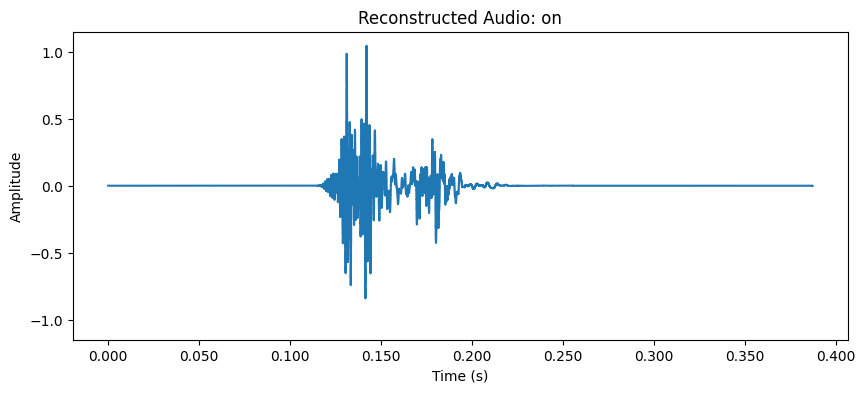

In [13]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import Audio

label_map = {0: 'bed', 1: 'bird', 2: 'cat', 3: 'dog', 4: 'down', 5: 'eight',
             6: 'five', 7: 'four', 8: 'go', 9: 'happy', 10: 'house', 11: 'left',
             12: 'marvin', 13: 'nine', 14: 'no', 15: 'off', 16: 'on', 17: 'one',
             18: 'right', 19: 'seven', 20: 'sheila', 21: 'six', 22: 'stop',
             23: 'three', 24: 'tree', 25: 'two', 26: 'up', 27: 'wow', 28: 'yes', 29: 'zero'}
HOP_LENGTH = N_FFT // 2 
# Loop through the batches
for batch in train_loader:
    audio, labels = batch
    
    # Extract the first sample
    mel_spectrogram = audio[0].numpy()  # Convert tensor to numpy
    label_idx = labels[0].item()  # Get the label index
    class_name = label_map[label_idx]  # Map to class name

    
    mel_power = librosa.db_to_power(mel_spectrogram)

    
    mel_to_linear = librosa.feature.inverse.mel_to_stft(
        mel_power, sr=SAMPLE_RATE, n_fft=N_FFT, power=1.0
    )

   
    waveform = librosa.griffinlim(mel_to_linear, hop_length=HOP_LENGTH, win_length=N_FFT)

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(waveform, sr=SAMPLE_RATE)
    plt.title(f"Reconstructed Audio: {class_name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

    # Play the reconstructed audio
    display(Audio(waveform, rate=SAMPLE_RATE))

    break 

In [20]:
for batch in train_loader:
    audios, labels = batch
    print(audios.shape) # (batch_size, mel_bins, time_step)
    print(audios[0].shape)
    print(audios[0])
    print(labels[0].shape)
    print(labels[0])
    break

torch.Size([32, 128, 32])
torch.Size([128, 32])
tensor([[-69.8824, -55.0456, -64.2032,  ..., -36.1804, -39.0825, -33.5294],
        [-65.9798, -51.1430, -60.3006,  ..., -32.2778, -35.1800, -29.6268],
        [-65.8163, -49.3593, -54.8985,  ..., -26.2588, -39.2823, -21.9453],
        ...,
        [-80.0000, -80.0000, -80.0000,  ..., -67.6752, -80.0000, -74.0204],
        [-80.0000, -80.0000, -80.0000,  ..., -69.7942, -80.0000, -74.1319],
        [-80.0000, -80.0000, -80.0000,  ..., -76.3468, -80.0000, -74.1273]])
torch.Size([])
tensor(18)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        scale = self.fc(x).view(x.size(0), x.size(1), 1, 1)
        return x * scale


class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU()
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv(x)
        return self.relu(out + identity)


class ImprovedSpeechCommandCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedSpeechCommandCNN, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.block1 = ResidualConvBlock(16, 32)
        self.block2 = ResidualConvBlock(32, 64)
        self.se = SEBlock(64)
        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(64 * 4 * 4, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # (B, 1, 128, 32)
        x = self.initial(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.se(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(label_map)
model = ImprovedSpeechCommandCNN(num_classes=num_classes).to(device)
print(model)

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CRNNTransformer(nn.Module):
    def __init__(self, num_classes=30, d_model=128, nhead=4, num_layers=4, dim_feedforward=256):
        super(CRNNTransformer, self).__init__()

        # CNN feature extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),          

            nn.Conv2d(16, 32, kernel_size=3, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))             
        )

        self.feature_dim = 32 * 32 
        self.seq_len = 8  # time steps 

        # Project CNN output to transformer input dimension
        self.input_proj = nn.Linear(self.feature_dim, d_model)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.positional_encoding = nn.Parameter(torch.randn(1, self.seq_len + 1, d_model))  # +1 for CLS

        # Classifier
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        
        x = x.unsqueeze(1)

        
        x = self.cnn(x)

        
        x = x.permute(0, 3, 1, 2)  
        x = x.contiguous().view(x.size(0), x.size(1), -1)  
        x = self.input_proj(x)  

        
        cls_token = self.cls_token.expand(x.size(0), -1, -1)  
        x = torch.cat([cls_token, x], dim=1)  

       
        x = x + self.positional_encoding[:, :x.size(1), :]

        # Transformer Encoder
        x = self.transformer(x)  

        # Use CLS token output
        cls_output = x[:, 0, :]  
        return self.fc(cls_output)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNNTransformer(num_classes=len(label_map)).to(device)

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionModule(nn.Module):
    def __init__(self, in_channels, attention_size):
        super(AttentionModule, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(in_channels, attention_size, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(attention_size, 1, kernel_size=1)
        )

    def forward(self, x):
        # x: (B, C, H, W)
        attn_weights = self.attention(x)  # (B, 1, H, W)
        attn_weights = F.softmax(attn_weights.view(x.size(0), -1), dim=1)
        attn_weights = attn_weights.view(x.size(0), 1, x.size(2), x.size(3))
        return x * attn_weights


class SpeechCommandCNNWithAttention(nn.Module):
    def __init__(self, num_classes):
        super(SpeechCommandCNNWithAttention, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )
        self.attention = AttentionModule(in_channels=64, attention_size=32)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(64 * 16 * 4, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # (B, 1, 128, 32)
        x = self.conv_block1(x)  # (B, 16, 64, 16)
        x = self.conv_block2(x)  # (B, 32, 32, 8)
        x = self.conv_block3(x)  # (B, 64, 16, 4)
        x = self.attention(x)    # Apply attention
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(label_map)
model = SpeechCommandCNNWithAttention(num_classes=num_classes).to(device)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class SpeechCommandCNN(nn.Module):
    def __init__(self, num_classes):
        super(SpeechCommandCNN, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),   
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))                          
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))                          
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))                          
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))                          
        )
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((2, 1))                          
        )
        self.conv_block6 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d((2, 1))                          
        )
        self.conv_block7 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))                          
        )

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512 * 1 * 1, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)            
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.dropout(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.dropout(x)
        x = self.conv_block6(x)
        x = self.conv_block7(x)
        x = x.view(x.size(0), -1)    
        x = self.dropout(x)
        x = self.fc(x)                
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(label_map)
model = SpeechCommandCNN(num_classes=num_classes).to(device)
print(model)

SpeechCommandCNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block4): Sequential(
    (0): Conv2d(64, 128, kernel_s

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

def train(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)

        for batch in loop:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

            # Update loop message
            loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        print(f'Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}, Accuracy = {100 * correct / total:.2f}%')

# Train the model
num_epochs = 15
train(model, train_loader, criterion, optimizer, device, num_epochs)


Epoch 1/15: 100%|██████████| 1285/1285 [00:14<00:00, 88.77it/s, accuracy=48, loss=0.871]  


Epoch 1: Loss = 1.7511, Accuracy = 48.04%


Epoch 2/15: 100%|██████████| 1285/1285 [00:14<00:00, 89.46it/s, accuracy=76.2, loss=1.08] 


Epoch 2: Loss = 0.7828, Accuracy = 76.15%


Epoch 3/15: 100%|██████████| 1285/1285 [00:14<00:00, 88.98it/s, accuracy=81.2, loss=0.504] 


Epoch 3: Loss = 0.6162, Accuracy = 81.19%


Epoch 4/15: 100%|██████████| 1285/1285 [00:14<00:00, 89.46it/s, accuracy=83.7, loss=0.339]


Epoch 4: Loss = 0.5283, Accuracy = 83.68%


Epoch 5/15: 100%|██████████| 1285/1285 [00:14<00:00, 89.08it/s, accuracy=85.4, loss=0.687]


Epoch 5: Loss = 0.4750, Accuracy = 85.36%


Epoch 6/15: 100%|██████████| 1285/1285 [00:14<00:00, 89.18it/s, accuracy=87, loss=0.526]   


Epoch 6: Loss = 0.4254, Accuracy = 87.02%


Epoch 7/15: 100%|██████████| 1285/1285 [00:14<00:00, 89.31it/s, accuracy=87.9, loss=0.569] 


Epoch 7: Loss = 0.3974, Accuracy = 87.87%


Epoch 8/15: 100%|██████████| 1285/1285 [00:14<00:00, 89.47it/s, accuracy=88.6, loss=0.628] 


Epoch 8: Loss = 0.3748, Accuracy = 88.60%


Epoch 9/15: 100%|██████████| 1285/1285 [00:14<00:00, 88.62it/s, accuracy=89.1, loss=0.323] 


Epoch 9: Loss = 0.3463, Accuracy = 89.12%


Epoch 10/15: 100%|██████████| 1285/1285 [00:14<00:00, 88.39it/s, accuracy=89.7, loss=0.424] 


Epoch 10: Loss = 0.3313, Accuracy = 89.66%


Epoch 11/15: 100%|██████████| 1285/1285 [00:14<00:00, 88.68it/s, accuracy=90.5, loss=0.0957]


Epoch 11: Loss = 0.3099, Accuracy = 90.49%


Epoch 12/15: 100%|██████████| 1285/1285 [00:14<00:00, 88.20it/s, accuracy=90.9, loss=0.528]  


Epoch 12: Loss = 0.2953, Accuracy = 90.90%


Epoch 13/15: 100%|██████████| 1285/1285 [00:14<00:00, 88.79it/s, accuracy=91.2, loss=0.515] 


Epoch 13: Loss = 0.2836, Accuracy = 91.17%


Epoch 14/15: 100%|██████████| 1285/1285 [00:14<00:00, 87.87it/s, accuracy=91.8, loss=0.254] 


Epoch 14: Loss = 0.2676, Accuracy = 91.77%


Epoch 15/15: 100%|██████████| 1285/1285 [00:14<00:00, 88.80it/s, accuracy=92, loss=0.79]    

Epoch 15: Loss = 0.2594, Accuracy = 91.97%


In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

def train(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)

        for batch in loop:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

            # Update loop message
            loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        print(f'Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}, Accuracy = {100 * correct / total:.2f}%')

# Train the model
num_epochs = 10
train(model, train_loader, criterion, optimizer, device, num_epochs)


Epoch 1/10: 100%|██████████| 1285/1285 [00:14<00:00, 89.09it/s, accuracy=95.7, loss=0.296]  


Epoch 1: Loss = 0.1346, Accuracy = 95.74%


Epoch 2/10: 100%|██████████| 1285/1285 [00:14<00:00, 89.28it/s, accuracy=95.9, loss=0.121]   


Epoch 2: Loss = 0.1322, Accuracy = 95.91%


Epoch 3/10: 100%|██████████| 1285/1285 [00:14<00:00, 89.32it/s, accuracy=95.8, loss=0.0548] 


Epoch 3: Loss = 0.1308, Accuracy = 95.83%


Epoch 4/10: 100%|██████████| 1285/1285 [00:14<00:00, 89.18it/s, accuracy=95.9, loss=0.209]  


Epoch 4: Loss = 0.1302, Accuracy = 95.87%


Epoch 5/10: 100%|██████████| 1285/1285 [00:14<00:00, 89.46it/s, accuracy=96, loss=0.17]     


Epoch 5: Loss = 0.1258, Accuracy = 96.00%


Epoch 6/10: 100%|██████████| 1285/1285 [00:14<00:00, 88.97it/s, accuracy=96, loss=0.157]   


Epoch 6: Loss = 0.1286, Accuracy = 96.00%


Epoch 7/10: 100%|██████████| 1285/1285 [00:14<00:00, 89.43it/s, accuracy=96, loss=0.22]     


Epoch 7: Loss = 0.1259, Accuracy = 95.98%


Epoch 8/10: 100%|██████████| 1285/1285 [00:14<00:00, 89.34it/s, accuracy=96.3, loss=0.0077] 


Epoch 8: Loss = 0.1188, Accuracy = 96.27%


Epoch 9/10: 100%|██████████| 1285/1285 [00:14<00:00, 88.95it/s, accuracy=96, loss=0.0678]   


Epoch 9: Loss = 0.1235, Accuracy = 96.02%


Epoch 10/10: 100%|██████████| 1285/1285 [00:14<00:00, 89.56it/s, accuracy=96.1, loss=0.291]  


Epoch 10: Loss = 0.1234, Accuracy = 96.11%


In [37]:
def evaluate(model, data_loader, criterion, device):
    """Evaluate the model"""
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(data_loader, desc="Evaluating", leave=True)

    for batch in loop:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Transpose inputs for transformer
        #inputs = inputs.transpose(1, 2)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item()
        
        loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(data_loader)
    
    print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

evaluate(model, test_loader, criterion, device)

Evaluating: 100%|██████████| 322/322 [00:01<00:00, 275.70it/s, accuracy=94.2, loss=0.00127]

Validation Loss: 0.2070, Accuracy: 94.20%


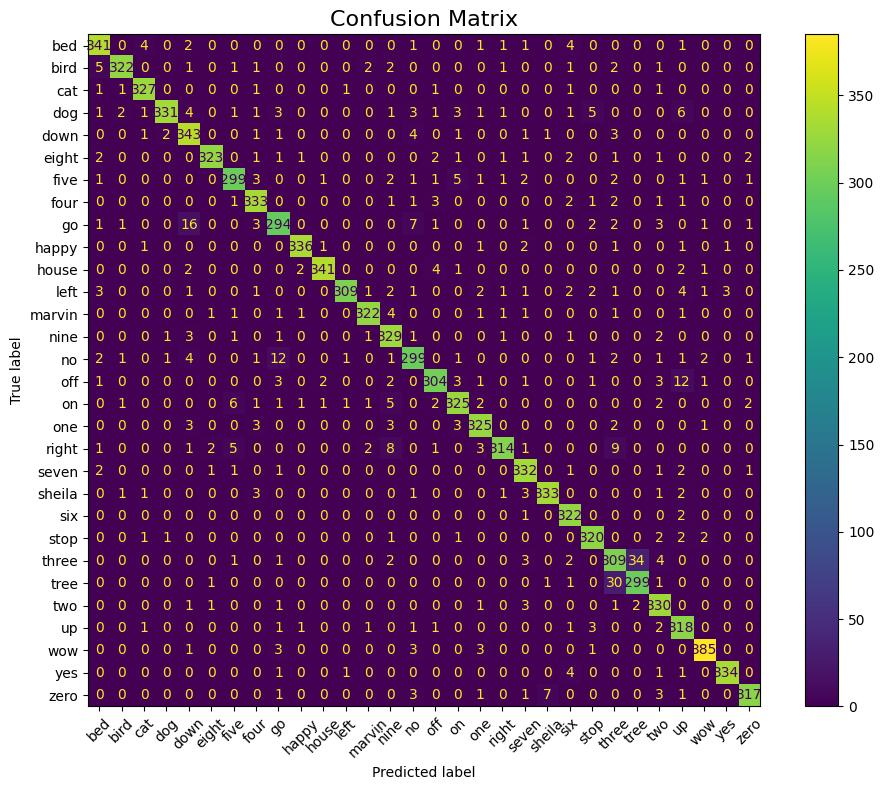

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_and_confusion_matrix(model, test_loader, device, label_map):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    display_labels = list(label_map.keys())

    fig, ax = plt.subplots(figsize=(10, 8))  # ← Increased size here
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(xticks_rotation=45, cmap='viridis', values_format='d', ax=ax)
    
    plt.title("Confusion Matrix", fontsize=16)
    plt.tight_layout()
    plt.show()

evaluate_and_confusion_matrix(model, test_loader, device, label_map)